# BASEP Trajectory Analysis

Now we have found the potential landscape shape, we are going to analize the trajectories of several particles in the system.

In [1]:
#Imports
%reset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.collections as mpc

import numpy as np
import scipy.optimize as opt
import pandas as pd
from pandas import DataFrame, Series

from tqdm import tqdm_notebook

idx = pd.IndexSlice
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# From aortiza's Microrheometer/Depinnig/support.py

#Function to establish the centre of a circle inthe origin. 
import scipy.optimize as spo
def get_center(trj):
    
    def calc_R(xc, yc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return np.sqrt((trj.x.values-xc)**2 + (trj.y.values-yc)**2)

    def f_2(c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        Ri = calc_R(*c)
        return Ri - Ri.mean()    

    center_estimate = 0, 0
    center, ir = spo.leastsq(f_2, center_estimate)
    return center

In [3]:
def changeToPolarCoordinates(t):
    
    #Obtention of the circle centre defined by the trajectory for each particle 
    center = get_center(t)
    t["x0"] = t.x-center[0]
    t["y0"] = t.y-center[1]

    #New calculation of the ro and theta coordinates with the coordinates origin correction 
    t["r"] = np.sqrt(t.x0**2 + t.y0**2)
    t["theta"] = np.arctan2(t.y0,t.x0)

    return t
#try to find the center for each individual particle taking into account the needing of sort by frame when locating 
#particles labels

In [4]:
def movementAnalyzer(t, timestamp, omega):
    
    t["theta_prime"] = np.mod(np.unwrap(t.theta)-omega*timestamp,2*np.pi) 
    t["theta_prime_unwrap"] = np.unwrap(t.theta_prime)
    t["d_theta_prime"] = t.theta_prime_unwrap.diff()
    
    t["theta_dot_prime"] = t.d_theta_prime/timestamp.diff()
    
    radius = t.r.mean()*0.1805 #0.1805 um/px

    t["arc_displace"] = t.d_theta_prime*radius
    t["arc_displace_prime"] = t.theta_dot_prime.diff()*radius
    
    return t

In [5]:
#Loading the tracking matrix from csv file 
filePath = "Tracking_Test2_20190116.dat"
t = pd.read_csv(filePath ,sep = "\t", index_col=[0])
t = t.set_index(["frame","particle"])
t = t.filter(["x","y"])
t = t.sort_index()
t.head()

x           y
frame particle                        
0     0         321.211420  113.025794
      1         334.316044  313.200811
      2         361.726841  309.390001
      3         306.191352  309.690605
      4         283.220798  300.866876

In [6]:
particles = t.index.get_level_values("particle").unique().tolist()

In [7]:
#Loading the timestamps of the video to have the time of each position
tmstmp_filePath = r"C:\Users\Eric\Desktop\BASEP_tests\20190116\Test2_2019_01_16_10_39_29.dat"
timestamp = pd.read_csv(tmstmp_filePath, sep="\r", header = None,names=["time"])

#Calculation of timestamps in nanoseconds
timestamp["datetime"] =  pd.to_datetime(timestamp.time+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))
timestamp["ellapsed_time"] = (timestamp.datetime-timestamp.datetime[0])
timestamp["time"] = timestamp.ellapsed_time.dt.total_seconds()
timestamp.head()

#to make it right, it would be better to make another column in the t DataFrame linking each frame and particle with
#the correct timestamp, but for the moment we can work with the timestamp DataFrame separately

,time,datetime,ellapsed_time
0,0.000000,2019-01-16 11:39:29.564000130,00:00:00
1,0.066999,2019-01-16 11:39:29.630999565,00:00:00.066999
2,0.134000,2019-01-16 11:39:29.697999954,00:00:00.133999
3,0.200000,2019-01-16 11:39:29.764000416,00:00:00.200000
4,0.267000,2019-01-16 11:39:29.830999851,00:00:00.266999


In [8]:
t = changeToPolarCoordinates(t)
t.head()

x           y         x0          y0           r  \
frame particle                                                              
0     0         321.211420  113.025794 -10.492690  -99.928104  100.477473   
      1         334.316044  313.200811   2.611934  100.246913  100.280935   
      2         361.726841  309.390001  30.022731   96.436103  101.001418   
      3         306.191352  309.690605 -25.512758   96.736707  100.044447   
      4         283.220798  300.866876 -48.483312   87.912978  100.395833   

                   theta  
frame particle            
0     0        -1.675415  
      1         1.544747  
      2         1.268985  
      3         1.828659  
      4         2.074784

(-10, 6.5)

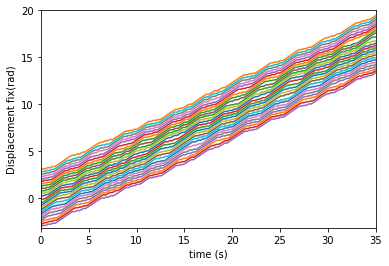

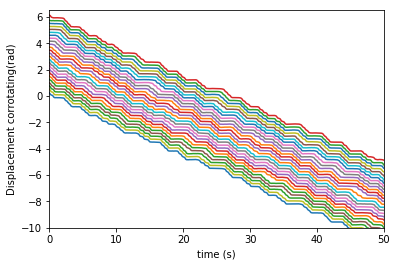

In [9]:
omega = 0.7

particle_i = pd.DataFrame()

f1 = plt.figure()
f2 = plt.figure()
ax1 = f1.add_subplot(111)
ax2 = f2.add_subplot(111)

t["theta_prime"] = np.NaN
t["theta_prime_unwrap"] = np.NaN
t["d_theta_prime"] = np.NaN
t["theta_dot_prime"] = np.NaN

for p, t_sub in tqdm_notebook(t.groupby("particle")):
    
    particle_i = t.loc[t.index.get_level_values("particle") == p].reset_index(drop=True)
    
    particle_i = changeToPolarCoordinates(particle_i)
    particle_i = movementAnalyzer(particle_i, timestamp.time, omega)
    
    particle_i.index = t.loc[idx[:,p],:].index

    t.loc[idx[:,p],"theta_prime"] = particle_i.theta_prime
    t.loc[idx[:,p],"theta_prime_unwrap"] = particle_i.theta_prime_unwrap
    t.loc[idx[:,p],"d_theta_prime"] = particle_i.d_theta_prime
    t.loc[idx[:,p],"theta_dot_prime"] = particle_i.theta_dot_prime
    
    ax1.plot(timestamp.time, np.unwrap(t.loc[idx[:,p],"theta"]))
    ax2.plot(timestamp.time, np.unwrap(t.loc[idx[:,p],"theta_prime"]))
    #plt.plot(timestamp.time, particle_i.arc_displace)
    #t.loc[t.particle == p] = particle_i
    
#plt.plot(timestamp.time, particle_i.arc_displace)
#plt.xlim([0, 2])
#plt.ylim([-.4, -1.2])
ax1.set_xlabel("time (s)")
ax1.set_ylabel("Displacement fix(rad)")
ax1.set_xlim(0,35)
ax1.set_ylim(-np.pi, 20)

ax2.set_xlabel("time (s)")
ax2.set_ylabel("Displacement corrotating(rad)")
ax2.set_xlim(0,50)
ax2.set_ylim(-10, 6.5)

# Particle density analysis

In [10]:
new_id = t.loc[idx[0,:],:].sort_values("theta").filter(["theta"])
new_id["id"] = range(0,len(new_id))
new_id = new_id.sort_index()
new_id.head()

theta  id
frame particle              
0     0        -1.675415   6
      1         1.544747  18
      2         1.268985  17
      3         1.828659  19
      4         2.074784  20

In [11]:
t["id"] = np.NaN
for i,trj_sub in t.groupby("particle"):
    t.loc[idx[:,i],"id"] = new_id.loc[idx[0,i],"id"]

t["frame"] = t.index.get_level_values("frame")
t["particle"] = t.index.get_level_values("particle")
t = t.set_index(["frame", "id", "particle"])
t = t.sort_index()
t.head()

x           y         x0         y0          r  \
frame id  particle                                                            
0     0.0 14        233.422357  203.387899 -98.281753  -9.565999  98.746197   
      1.0 23        238.215651  181.177320 -93.488459 -31.776578  98.741292   
      2.0 21        247.438914  160.394103 -84.265196 -52.559795  99.313419   
      3.0 24        261.915284  142.547186 -69.788826 -70.406712  99.134178   
      4.0 17        279.044801  128.064053 -52.659309 -84.889845  99.896390   

                       theta  theta_prime  theta_prime_unwrap  d_theta_prime  \
frame id  particle                                                             
0     0.0 14       -3.044566     3.238604            3.238604            NaN   
      1.0 23       -2.813945     3.469420            3.469420            NaN   
      2.0 21       -2.583898     3.699506            3.699506            NaN   
      3.0 24       -2.351787     3.931403            3.931403            NaN   
      4.0 17       -2.126027     4.157201            4.157201            NaN   

                    theta_dot_prime  
frame id  particle                   
0     0.0 14                    NaN  
      1.0 23                    NaN  
      2.0 21                    NaN  
      3.0 24                    NaN  
      4.0 17                    NaN

In [12]:
t["delta"] = np.NaN
t["delta_prime"] = np.NaN

for frm,trj_sub in tqdm_notebook(t.groupby("frame")):
    A = np.roll(trj_sub.theta,1)
    t.loc[idx[frm,:],"delta"] = t.loc[idx[frm,:],"theta"]-A
    B = np.roll(trj_sub.theta_prime,1)
    t.loc[idx[frm,:],"delta_prime"] = t.loc[idx[frm,:],"theta_prime"]-B
    
t.head()

x           y         x0         y0          r  \
frame id  particle                                                            
0     0.0 14        233.422357  203.387899 -98.281753  -9.565999  98.746197   
      1.0 23        238.215651  181.177320 -93.488459 -31.776578  98.741292   
      2.0 21        247.438914  160.394103 -84.265196 -52.559795  99.313419   
      3.0 24        261.915284  142.547186 -69.788826 -70.406712  99.134178   
      4.0 17        279.044801  128.064053 -52.659309 -84.889845  99.896390   

                       theta  theta_prime  theta_prime_unwrap  d_theta_prime  \
frame id  particle                                                             
0     0.0 14       -3.044566     3.238604            3.238604            NaN   
      1.0 23       -2.813945     3.469420            3.469420            NaN   
      2.0 21       -2.583898     3.699506            3.699506            NaN   
      3.0 24       -2.351787     3.931403            3.931403            NaN   
      4.0 17       -2.126027     4.157201            4.157201            NaN   

                    theta_dot_prime     delta  delta_prime  
frame id  particle                                          
0     0.0 14                    NaN -6.056989     0.226003  
      1.0 23                    NaN  0.230621     0.230816  
      2.0 21                    NaN  0.230047     0.230085  
      3.0 24                    NaN  0.232111     0.231897  
      4.0 17                    NaN  0.225760     0.225798

In [13]:
jumps = t[np.abs(t.delta)>np.pi].index
t.loc[jumps,"delta"] = (2*np.pi-np.abs(t.loc[jumps].delta))


In [14]:
def fill_between_array(x,y1,y2,array=None,**kargs):
    """ 
    Create collection of polygons between two curves, y1 and y2. 
    the input array can be used to impose a mapping to a colormap.
    """
    p = [((x[i],y1[i]),(x[i+1],y1[i+1]),(x[i+1],y2[i+1]),(x[i],y2[i]))
         for i,d in enumerate(x[:-2])]
    
    Poly = plt.gca().add_collection(mpc.PolyCollection(p,**kargs))
    Poly.set_array(array)

    return Poly

Text(0,0.5,'theta unwrapped (rad)')

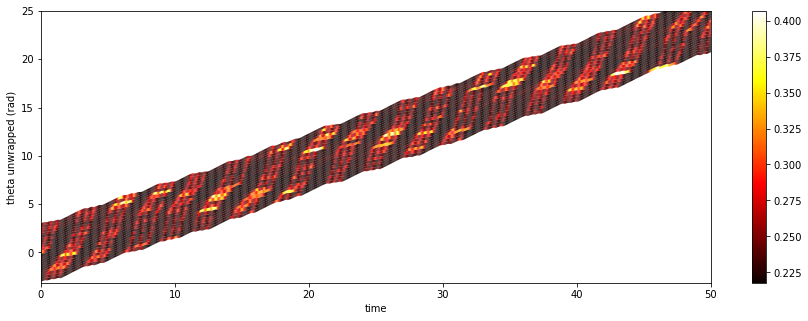

In [15]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

x = timestamp.time

for part in tqdm_notebook(t.index.get_level_values("id").unique()[:-1]):
    
    y1 = np.unwrap(t.loc[idx[:,part],:].theta.values)
    y2 = np.unwrap(t.loc[idx[:,part+1],:].theta.values)
    
    Poly = fill_between_array(x,y1,y2,
                          array = t.loc[idx[:,part],:].delta,cmap="hot")
    #Poly.set_clim(0.25, 0.5)

plt.colorbar(Poly)
plt.xlim([0,50])
plt.ylim([-np.pi,25])
plt.xlabel("time")
plt.ylabel("theta unwrapped (rad)")

In [16]:
t["frame"] = t.index.get_level_values("frame")
t["particle"] = t.index.get_level_values("particle")
t = t.set_index(["frame", "particle"])
t = t.sort_index()
new_id_prime = t.loc[idx[0,:],:].sort_values("theta_prime").filter(["theta_prime"])
new_id_prime["id"] = range(0,len(new_id))
new_id_prime = new_id.sort_index()
new_id_prime.head()

theta  id
frame particle              
0     0        -1.675415   6
      1         1.544747  18
      2         1.268985  17
      3         1.828659  19
      4         2.074784  20

In [17]:
t["id"] = np.NaN
for i,trj_sub in t.groupby("particle"):
    t.loc[idx[:,i],"id"] = new_id_prime.loc[idx[0,i],"id"]

t["frame"] = t.index.get_level_values("frame")
t["particle"] = t.index.get_level_values("particle")
t = t.set_index(["frame", "id", "particle"])
t = t.sort_index()
t.head()

x           y         x0         y0          r  \
frame id  particle                                                            
0     0.0 14        233.422357  203.387899 -98.281753  -9.565999  98.746197   
      1.0 23        238.215651  181.177320 -93.488459 -31.776578  98.741292   
      2.0 21        247.438914  160.394103 -84.265196 -52.559795  99.313419   
      3.0 24        261.915284  142.547186 -69.788826 -70.406712  99.134178   
      4.0 17        279.044801  128.064053 -52.659309 -84.889845  99.896390   

                       theta  theta_prime  theta_prime_unwrap  d_theta_prime  \
frame id  particle                                                             
0     0.0 14       -3.044566     3.238604            3.238604            NaN   
      1.0 23       -2.813945     3.469420            3.469420            NaN   
      2.0 21       -2.583898     3.699506            3.699506            NaN   
      3.0 24       -2.351787     3.931403            3.931403            NaN   
      4.0 17       -2.126027     4.157201            4.157201            NaN   

                    theta_dot_prime     delta  delta_prime  
frame id  particle                                          
0     0.0 14                    NaN  0.226196     0.226003  
      1.0 23                    NaN  0.230621     0.230816  
      2.0 21                    NaN  0.230047     0.230085  
      3.0 24                    NaN  0.232111     0.231897  
      4.0 17                    NaN  0.225760     0.225798

In [18]:
t["delta_prime"] = np.NaN

for frm,trj_sub in tqdm_notebook(t.groupby("frame")):
    B = np.roll(trj_sub.theta_prime,1)
    t.loc[idx[frm,:],"delta_prime"] = t.loc[idx[frm,:],"theta_prime"]-B
    
t.head()

x           y         x0         y0          r  \
frame id  particle                                                            
0     0.0 14        233.422357  203.387899 -98.281753  -9.565999  98.746197   
      1.0 23        238.215651  181.177320 -93.488459 -31.776578  98.741292   
      2.0 21        247.438914  160.394103 -84.265196 -52.559795  99.313419   
      3.0 24        261.915284  142.547186 -69.788826 -70.406712  99.134178   
      4.0 17        279.044801  128.064053 -52.659309 -84.889845  99.896390   

                       theta  theta_prime  theta_prime_unwrap  d_theta_prime  \
frame id  particle                                                             
0     0.0 14       -3.044566     3.238604            3.238604            NaN   
      1.0 23       -2.813945     3.469420            3.469420            NaN   
      2.0 21       -2.583898     3.699506            3.699506            NaN   
      3.0 24       -2.351787     3.931403            3.931403            NaN   
      4.0 17       -2.126027     4.157201            4.157201            NaN   

                    theta_dot_prime     delta  delta_prime  
frame id  particle                                          
0     0.0 14                    NaN  0.226196     0.226003  
      1.0 23                    NaN  0.230621     0.230816  
      2.0 21                    NaN  0.230047     0.230085  
      3.0 24                    NaN  0.232111     0.231897  
      4.0 17                    NaN  0.225760     0.225798

In [19]:
jumps = t[np.abs(t.delta_prime)>np.pi].index
t.loc[jumps,"delta_prime"] = (2*np.pi-np.abs(t.loc[jumps].delta_prime))

In [20]:
t

x           y          x0          y0  \
frame id   particle                                                   
0     0.0  14        233.422357  203.387899  -98.281753   -9.565999   
      1.0  23        238.215651  181.177320  -93.488459  -31.776578   
      2.0  21        247.438914  160.394103  -84.265196  -52.559795   
      3.0  24        261.915284  142.547186  -69.788826  -70.406712   
      4.0  17        279.044801  128.064053  -52.659309  -84.889845   
      5.0  16        299.172822  117.841668  -32.531288  -95.112230   
      6.0  0         321.211420  113.025794  -10.492690  -99.928104   
      7.0  19        343.872315  112.560811   12.168205 -100.393087   
      8.0  15        365.809643  117.480930   34.105533  -95.472968   
      9.0  18        387.491138  127.652182   55.787028  -85.301716   
      10.0 20        406.480434  143.747199   74.776324  -69.206699   
      11.0 22        420.289365  161.796149   88.585255  -51.157749   
      12.0 13        432.760503  199.142143  101.056393  -13.811755   
      13.0 10        430.040193  238.639397   98.336083   25.685499   
      14.0 8         420.504301  264.109481   88.800191   51.155583   
      15.0 12        405.510275  283.841275   73.806165   70.887378   
      16.0 5         386.890605  298.187898   55.186495   85.234000   
      17.0 2         361.726841  309.390001   30.022731   96.436103   
      18.0 1         334.316044  313.200811    2.611934  100.246913   
      19.0 3         306.191352  309.690605  -25.512758   96.736707   
      20.0 4         283.220798  300.866876  -48.483312   87.912978   
      21.0 6         264.405203  286.627444  -67.298907   73.673546   
      22.0 7         249.516031  269.088713  -82.188079   56.134815   
      23.0 9         239.005718  248.764117  -92.698392   35.810219   
      24.0 11        233.149067  225.755490  -98.555043   12.801593   
1     0.0  14        233.742513  198.287253  -97.961597  -14.666644   
      1.0  23        239.513601  176.439096  -92.190509  -36.514802   
      2.0  21        249.819924  156.313670  -81.884186  -56.640228   
      3.0  24        265.123473  139.221902  -66.580637  -73.731996   
      4.0  17        282.920899  125.872046  -48.783211  -87.081852   
...                         ...         ...         ...         ...   
9671  20.0 4         336.950706  313.855180    5.246596  100.901282   
      21.0 6         312.640812  312.305483  -19.063298   99.351585   
      22.0 7         289.110347  304.609557  -42.593763   91.655659   
      23.0 9         267.199302  290.491649  -64.504808   77.537751   
      24.0 11        248.592621  270.271099  -83.111489   57.317201   
9672  0.0  14        237.015646  247.997549  -94.688464   35.043652   
      1.0  23        230.342906  223.114684 -101.361204   10.160786   
      2.0  21        231.725842  198.333425  -99.978268  -14.620473   
      3.0  24        237.059284  173.927992  -94.644826  -39.025905   
      4.0  17        248.881406  152.849399  -82.822704  -60.104499   
      5.0  16        265.862508  135.477100  -65.841602  -77.476798   
      6.0  0         287.229208  121.919543  -44.474902  -91.034354   
      7.0  19        314.070559  114.473645  -17.633551  -98.480253   
      8.0  15        343.530276  113.736803   11.826166  -99.217095   
      9.0  18        369.590013  119.692076   37.885903  -93.261822   
      10.0 20        389.578801  130.724674   57.874691  -82.229224   
      11.0 22        406.844911  146.412127   75.140801  -66.541771   
      12.0 13        420.840103  167.709739   89.135993  -45.244159   
      13.0 10        429.489880  201.964580   97.785770  -10.989318   
      14.0 8         429.820636  225.957182   98.116526   13.003284   
      15.0 12        424.461198  251.053455   92.757088   38.099557   
      16.0 5         412.344618  271.673397   80.640508   58.719499   
      17.0 2         397.246413  288.816356   65.542303   75.862458   
      18.0 1         377.364010  301.945403   45.65990

Text(0,0.5,'theta prime unwrapped (rad)')

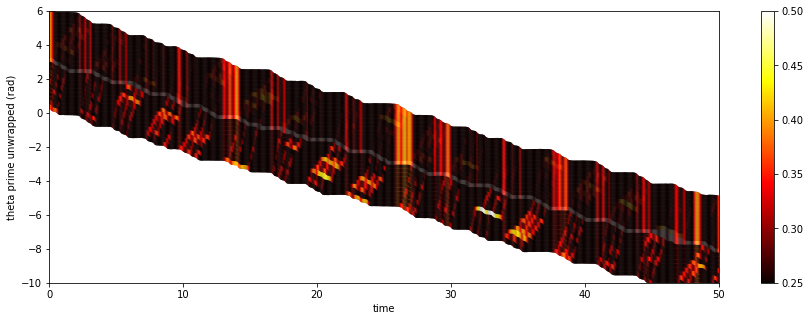

In [21]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

for part in tqdm_notebook(t.index.get_level_values("id").unique()[:-1]):
    
    y1 = np.unwrap(t.loc[idx[:,part],:].theta_prime.values)
    y2 = np.unwrap(t.loc[idx[:,part+1],:].theta_prime.values)
    
    Poly = fill_between_array(x,y1,y2,
                          array = t.loc[idx[:,part],:].delta_prime,cmap="hot")
    Poly.set_clim(0.25, 0.5)

plt.colorbar(Poly)
plt.xlim([0,50])#([0,10])
plt.ylim([-10,6])#([-3,6.5])
plt.xlabel("time")
plt.ylabel("theta prime unwrapped (rad)")